In [8]:
import ast

json_file = 'output_20211125/metrics.json'

parsed_lines = []

with open(json_file) as f:
    lines = f.readlines()
    for line in lines:
        metrics = ast.literal_eval(line)
        parsed_lines.append(metrics)

In [9]:
parsed_lines[0]['iteration'], parsed_lines[0]['total_loss']

(19, 1.826599451713264)

In [10]:
total_losses_x = []
total_losses_y = []
val_losses_x = []
val_losses_y = []

for i in range(len(parsed_lines)-1):
    if 'total_loss' in parsed_lines[i]:
        total_losses_x.append(parsed_lines[i]['iteration'])
        total_losses_y.append(parsed_lines[i]['total_loss'])
    
    if 'validation_loss' in parsed_lines[i]:
        val_losses_x.append(parsed_lines[i]['iteration'])
        val_losses_y.append(parsed_lines[i]['validation_loss'])
        

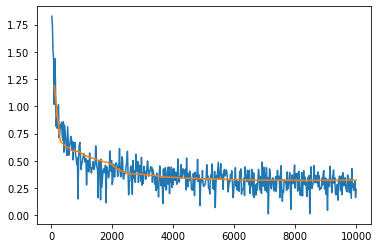

In [11]:
import matplotlib.pyplot as plt

plt.plot(total_losses_x, total_losses_y)
plt.plot(val_losses_x, val_losses_y)
plt.show()

In [1]:
import cv2
import torch
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

In [2]:
watermarks_metadata = MetadataCatalog.get("watermarks_train")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.WEIGHTS = 'models/watermark/detectron2.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

im = cv2.imread('dataset/benchmarkv2/clean_Img_001301.jpg')
output = predictor(im)

In [24]:
output['instances'].pred_masks[0]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

In [27]:
lbl = output['instances'].pred_masks[0].cpu().numpy().reshape(-1)
target = output['instances'].pred_masks[1].cpu().numpy().reshape(-1)

In [34]:
len(lbl), len(target)

(318888, 318888)

In [32]:
import numpy as np
c = np.logical_and(lbl, lbl)
c.sum()

1109

In [38]:
type(c)

numpy.ndarray

Other params:

face_foregroun_background_res: OpenCV Grayscale (3-channel) Mask (618, 516, 3)

background_check_result: {"status": status, "remarks": remarks}

face_highlight_res: {"res_img_cv": v.get_image()[:, :, ::-1], "res_highlight_mask": bin_mask}
    bin_mask: np.zeros((h, w)) (618, 516)

If ```background_check_result["status"] == 0``` means background not white => use face_foregroun_background_res to remove all instances in background

In [54]:
idxofClass = []

In [56]:
classes = output['instances'].pred_classes[idxofClass]
scores = output['instances'].scores[idxofClass]
boxes = output['instances'].pred_boxes[idxofClass]
masks = output['instances'].pred_masks[idxofClass]

In [58]:
import detectron2

obj = detectron2.structures.Instances(image_size=(480, 640))

obj.set('pred_classes', classes)
obj.set('scores', scores)
obj.set('pred_boxes', boxes)
obj.set('pred_masks', masks)

Use instances in face_highlight_res["res_highlight_mask"] to remove instances that have overlap

In [ ]:
v = Visualizer(im[:, :, ::-1],
                metadata=watermarks_metadata,
                scale=1,
                instance_mode=ColorMode.IMAGE_BW  # remove the colors of unsegmented pixels
                )
v = v.draw_instance_predictions(output["instances"].to("cpu"))

cv2.imshow("Watermark Check", cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
cv2.waitKey(0)